## Unsupervised Learning with Max-cut
This notebook is an example of unsupervised learning on a quantum computer. The data used are from the iris data set.

Both classical and quantum methods are used to classify the iris dataset. First, the classical k-means clustering algorithm is walked through. Second, the max-cut problem is mapped to an Ising Hamiltonian and solved using QAOA. A kaggle tutorial [[1](#1)] on k-means, a qiskit tutorial [[2](#2)] on max-cut, and the paper *Unsupervised Machine Learning on a Hybrid Quantum Computer* [[3](#3)] were helpful aids in constructing this notebook and make for interesting reading.

The next notebook ([Max-cut 2+ Divisive Clustering](https://github.com/ajrazander/Unsupervised-QML/blob/master/Max-cut%202%2B%20Divisive%20Clustering.ipynb)) explores how to cluster data into 2+ groups using the same binary classifier approach explored here (i.e. QAOA solving the max-cut problem).

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans

In [2]:
# Import Iris dataset
df = pd.read_csv('Data/iris.csv')
df.drop(["Id"],axis=1,inplace=True)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Let's look at the data by species to get an idea of how we expect the classical and quantum algorithms to classify the data. Since the quantum computer will be simulated on my laptop, <strong>let's reduce the dataset</strong> for a faster run time.

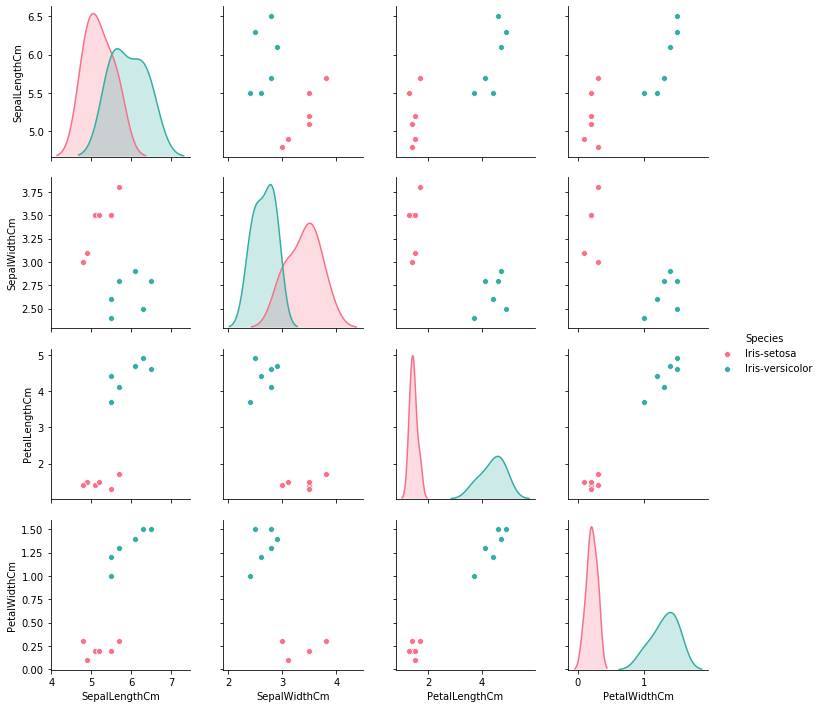

In [3]:
# Generate subset of data with fewer data points
df_sub = df.iloc[::9,:].reset_index(drop=True)

# Constrain data to only 2 species
df_sub = df_sub.loc[(df_sub['Species'] == 'Iris-setosa') | (df_sub['Species'] == 'Iris-versicolor')]

# View data with known labels as a control to compare future clustering done by k-means and QAOA
sns.pairplot(data=df_sub,hue="Species",palette="husl")
plt.show()

# A Classical Approach
The k-means algorithm is an unsupervised machine learning method. K-means will cluster data into k groups based on minimizing each cluster's sum-of-sqaures also known as inertia

$$
\sum_{i=0}^{n} \min_{u_j \in C}(\lvert\lvert x_i - u_j\rvert\rvert^2)
$$

where $\mu_j$ is the mean of the jth cluster within the set $C$ of clusters.
(see scikit-learn's [clustering userguide](https://scikit-learn.org/stable/modules/clustering.html#k-means) for more details). The optimal number of clusters k is known for this data ($k=2$) since the reduced dataset only contains two species. However, we will predent that is unknown. Comparison between the actual species label and how k-means clusters the data will be a performance metric for this and the quantum approach. Since the optimal k is unknown, let's use the [elbow rule](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) to determine the optimal k.

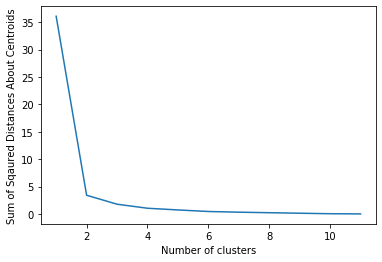

In [4]:
# Use k-means as classical unsupervised learning method (compare to quantum method later)

# Remove Iris labels (otherwise it's not unsurpervised learning!)
data = df_sub.loc[:,['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']]
data.head()

# Use elbow rule to choose optimal k
dis = []
K = range(1,len(data))
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    dis.append(kmeans.inertia_)

# Visualize Optimal k
plt.plot(K,dis)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Sqaured Distances About Centroids')
plt.show()

Looks like 2 (maybe 3?) is most elbowy and thus the optimal k. Let's fit then visualize the k-means algorithm with the optimal k.

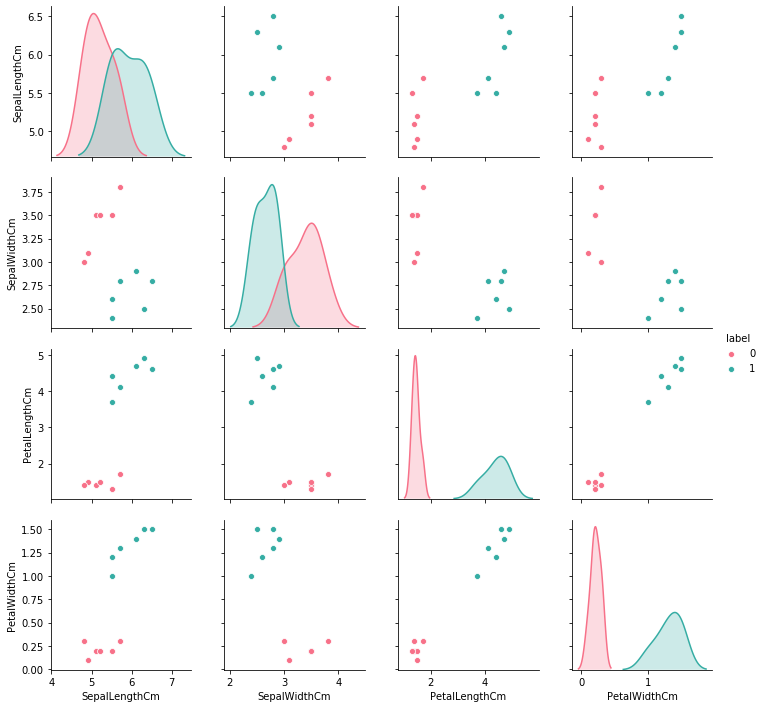

In [5]:
# Use optimal k for final k-means model
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(data)

# Add k-means labeling to dataframe for later comparison
df_sub['label'] = kmeans.labels_

# Visualize clustering done by k-means algorithm
sns.pairplot(data=df_sub,hue='label',palette="husl",vars=df_sub.columns[:-2])
plt.show()

The plots looks identical to the reduced dataset. This is directly confirmed below where we see Iris-setosa is 100% in cluster 1 and Iris-versicolor is 100% in cluster 0.

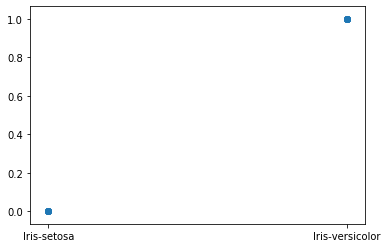

"Average" label classification:
Species
Iris-setosa        0.0
Iris-versicolor    1.0
Name: label, dtype: float64


In [6]:
# Calculate percent of miss labeled data points
plt.scatter(df_sub['Species'], df_sub['label'])
plt.show()

print('\"Average\" label classification:')
print(df_sub.groupby(['Species']).sum()['label'] / df_sub.groupby(['Species']).count()['label'])

With k = 2, the k-means algorithm clustering is 100% accurate on this subset of the iris dataset! The elbow rule pulled through! Let's see how the quantum computer fairs.

# A Quantum Approach

One approach to unsurpervised quantum machine learning is to map the problem to a graph optimization problem (specifically max-cut in this notebook). The graph optimization problem can then be mapped to a cost Hamiltonian, which can quickly be solved by a quantum computer.

## Make a Graph

The first step in mapping data to a graph is calculating the pairwise "distances" between each data point. These distances will weight the edges of the graph. There are different ways to measure "distance." We will simply use the $l^2\text{-norm}$ (i.e. vector magnitude). Again, we'll be using a subset of the iris dataset to facilitate fast simulation of a quantum computer. 

In [7]:
# Remove Iris labels
data = df_sub.loc[:,['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']]

# Get number of data entries
n_instances = len(data)

# Convert dataframe into array
data_array = data.values

# Calculate pairwise L2-norms
w = np.zeros((n_instances, n_instances))
for i in range(0,n_instances):
    for j in range(0,n_instances):
        w[i, j] = np.linalg.norm(data_array[i]-data_array[j])

print('Weight matrix size:',w.shape)

Weight matrix size: (12, 12)


To seperate the graph into clusters, the graph is cut with a [max-cut](https://en.wikipedia.org/wiki/Maximum_cut): meaning the graph is seperated in two while maximizing total weight of the 'cut' edges. This is an NP-hard problem. However, it maps to an Ising model, so there is a quantum speedup! [[3](#3)]

We can interpret the output of the Ising model as follows. The spin variables $\hat{\sigma}_i^z \in \{-1, +1\}$ take on the value $\hat{\sigma}_i^z = +1$ for data in cluster 1, and $\hat{\sigma}_i^z = -1$ for data in cluster 2! The cost of one cut between nodes $i$ and $j$ is the edge's weight $w_{ij}$ that lies between them. In seperating the graph into two sets of nodes ($S_1$ for cluster 1 and $S_2$ for cluster 2), the total weight cut

$$
w(\delta(S)) = \sum_{i\in S_1, j\in S_2} w_{ij}.
$$

Assuming a fully connected graph and accounting for the symmetry of $w_{ij}$ (i.e. $w_{ij} = w_{ji}$), the sum can be expanded to
$$
\begin{align}
w(\delta(S)) & = \frac{1}{2}\sum_{(ij) \in \delta(S_1)} w_{ij} \\
& = \frac{1}{4}\sum_{ij} w_{ij} - \frac{1}{4} \sum_{ij} w_{ij} \hat{\sigma}_i^z \hat{\sigma}_j^z \\
& = \frac{1}{4}\sum_{ij} w_{ij} (1- \hat{\sigma}_i^z \hat{\sigma}_j^z).
\end{align}
$$                 

By taking the negative of this, we can explicity see it's connection to the Ising Hamiltonian (external field $h = 0$ and constant $C$)

$$
H_{ising} = \sum_{ij}J_{ij}\hat{\sigma}_i^z\hat{\sigma}_j^z + C.
$$

Now that the max-cut is mapped to the Ising Hamiltonian, a quantum computer can efficiently find the max-cut by finding the ground state of $H_{ising}$. Note, the Ising model conventionally written as a sum over all **nearest neighbor** pairs $\sum_{<ij>}$. Since the graph is fully connected (or can be made fully connected by adding edges of weight zero), $\sum_{<ij>}$ is identical to $\sum_{ij}$.

More details on the derivation can be found in the paper *Unsupervised Machine Learning on a Hybrid Quantum Computer* [[3](#3)]

## Solve the Max-cut Problem with QAOA

[Qiskit](https://qiskit.org) will be used to implement QAOA. QAOA is a quantum optimizer that will adiabatically find the ground state of the cost Hamiltonian--exactly what we need!

In [8]:
# Quantum Computing packages
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.translators.ising import max_cut
from qiskit.aqua.components.optimizers import COBYLA

In [9]:
# QAOA hyperparameters and initialization
p = 1  # Number of adiabatic steps must be > 0
optimizer = COBYLA()
qubit_ops, offset = max_cut.get_max_cut_qubitops(w)
qaoa = QAOA(qubit_ops, optimizer, p)

# Initialize quantum simulator
backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, shots=1)

In [10]:
# Execute QAOA on quantum simulator
result = qaoa.run(quantum_instance)

# Extract clustering solution from result variable
x = max_cut.sample_most_likely(result['eigvecs'][0])

# Show results
print('energy:', result['energy'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

energy: -14.330097421145284
max-cut objective: -85.92565466016447
solution: [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
solution objective: 120.69884228703256


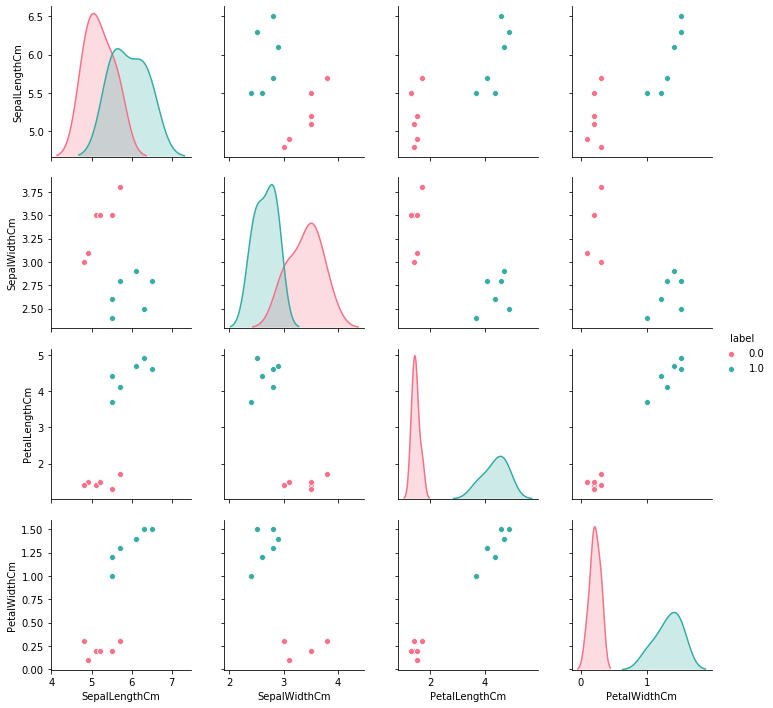

"Average" label classification:
Species
Iris-setosa        0.0
Iris-versicolor    1.0
Name: label, dtype: float64


In [11]:
# Extract labels and include them in df_sub
labels = pd.DataFrame(max_cut.get_graph_solution(x),columns=['label'])
df_sub['label'] = labels

# Show data by cluster
sns.pairplot(data=df_sub,hue='label',palette="husl",vars=df_sub.columns[:-2])
plt.show()

# Display cluster label mean by species
print('\"Average\" label classification:')
print(df_sub.groupby(['Species']).sum()['label'] / df_sub.groupby(['Species']).count()['label'])

The plots looks identical to the reduced dataset--again! This is directly confirmed by the "average" label classification. All of Iris-setosa is in cluster 0 and all of Iris-versicolor is in cluster 1.

# References

[1] Unsupervised Learning on Iris. (accessed 2019). [Kaggle Tutorial](https://www.kaggle.com/efeergun96/unsupervised-learning-on-iris). <a id='1'></a>

[2] Max-Cut. (accessed 2019). [Qiskit Tutorial](https://github.com/qiskit-community/qiskit-qcgpu-provider/blob/master/examples/aqua/Max-Cut.ipynb).  <a id='2'></a>

[3] Otterbach, J. S., et al. (2017). [Unsupervised Machine Learning on a Hybrid Quantum Computer](https://arxiv.org/abs/1712.05771). *arXiv:1712.05771*. <a id='3'></a>